https://python.langchain.com/docs/integrations/vectorstores/neo4jvector/

In [1]:
url = "bolt://localhost:7687"
username = "neo4j"
password = "password"

In [3]:
from langchain_neo4j import Neo4jVector
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import CharacterTextSplitter
import os
from langchain_openai import AzureOpenAIEmbeddings
from dotenv import load_dotenv

load_dotenv()
embeddings = AzureOpenAIEmbeddings(
openai_api_type="azure",
openai_api_version=os.environ["OPENAI_API_EMBEDDING_VERSION"],
openai_api_key=os.environ["OPENAI_API_EMBEDDING_KEY"],
azure_endpoint=os.environ["AZURE_OPENAI_EMBEDDING_ENDPOINT"],
deployment=os.environ["AZURE_OPENAI_EMBEDDING_DEPLOYMENT"],
model=os.environ["AZURE_OPENAI_EMBEDDING_MODEL"],
validate_base_url=True,
)


vector_store = Neo4jVector.from_existing_index(
    embeddings,
    url=url,
    username=username,
    password=password,
    index_name="neo4j"
)

In [4]:
vector_store.similarity_search("generate react-agent")

[Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/how-tos/react-agent-from-scratch'}, page_content='## Use ReAct agent¶\n\nNow that we have created our react agent, let\'s actually put it to the test!\n\n    \n    \n    # Helper function for formatting the stream nicely\n    def print_stream(stream):\n        for s in stream:\n            message = s["messages"][-1]\n            if isinstance(message, tuple):\n                print(message)\n            else:\n                message.pretty_print()\n    \n    \n    inputs = {"messages": [("user", "what is the weather in sf")]}\n    print_stream(graph.stream(inputs, stream_mode="values"))\n    \n    \n    \n    ================================\x1b Human Message \x1b=================================\n    \n    what is the weather in sf\n    ==================================\x1b Ai Message \x1b==================================\n    Tool Calls:\n      get_weather (call_azW0cQ4XjWWj0IAkWAxq9nLB)\n     Call ID: call_a

In [5]:
retriever = vector_store.as_retriever()
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)

tools = [retriever_tool]

In [6]:
from typing import Literal
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field


from langgraph.prebuilt import tools_condition
from langchain_core.prompts import PromptTemplate


### Edges


def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


### Nodes
planner_prompt = """
<Task>
You will help plan the steps to implement a LangGraph application based on the user's request. 
</Task>

<Instructions>
1. Reflect on the user's request and the project scope
2. Use the retrieval tool to get access to the LangGraph documentation.
3. Do not hallucinate or generate langgraph code on your own, only trust the accessed information. 
</Instructions>
"""

def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o-mini")
    model = model.bind_tools(tools)
    response = model.invoke([SystemMessage(content=planner_prompt)]  + messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}



def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    
    prompt = PromptTemplate.from_template(
"""Your job is to generate python code for the user query using langgraph sdk.
1. Do not hallucinate when generating code.
2. Only refer to the context shared with you

<context>
{context}
</context>

<query>
{question}
<query>
""")

    # LLM
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [9]:
from langgraph.graph import END, StateGraph, START, MessagesState
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

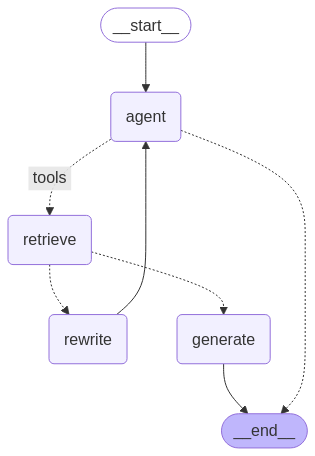

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [11]:
import pprint

inputs = {
    "messages": [
        ("user", "Write Langgraph code Web Research (STORM)"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_m8jtKFV1fsmy1DtViFomA57D', 'function': {'arguments': '{"query":"LangGraph Web Research STORM"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_86d0290411'}, id='run-a1fe0109-cab8-4807-9786-d4c56e65e83c-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'LangGraph Web Research STORM'}, 'id': 'call_m8jtKFV1fsmy1DtViFomA57D', 'type': 'tool_call'}])]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='## Final Flow¶\n\nNow it\'s time to string everything together. We will have 6 main stages in\nsequence: . 1\\. Generate the initial outline + perspectives 2\\. Batch converse\nwith each perspective to expand the content for t

In [12]:

inputs = {
    "messages": [
        ("user", "Implement a Plan-And-Execute Agent"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_GRXUxnlroNsRTFFQXUNpkWIo', 'function': {'arguments': '{"query":"Plan-And-Execute Agent"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_86d0290411'}, id='run-1fe4e5a6-27fb-4a43-9672-bb42add7155d-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'Plan-And-Execute Agent'}, 'id': 'call_GRXUxnlroNsRTFFQXUNpkWIo', 'type': 'tool_call'}])]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='![plan-and-execute\n\n[ ](https://github.com/langchain-\nai/langgraph/edit/main/docs/docs/tutorials/plan-and-execute/plan-and-\nexecute.ipynb "Edit this page")\n\n# Plan-and-Execute¶\n\nThis notebook shows how to create a "plan-and-execut

In [13]:

inputs = {
    "messages": [
        ("user", "Implement a supervisor agent"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_AgQ2xywXeISNl3hgbDpoZ0Vg', 'function': {'arguments': '{"query":"supervisor agent"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_86d0290411'}, id='run-f5d3c2ec-dac6-456f-bf75-e7e855927b62-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'supervisor agent'}, 'id': 'call_AgQ2xywXeISNl3hgbDpoZ0Vg', 'type': 'tool_call'}])]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='[ ](https://github.com/langchain-\nai/langgraph/edit/main/docs/docs/tutorials/multi_agent/agent_supervisor.ipynb\n"Edit this page")\n\n# Multi-agent supervisor¶\n\nThe [previous example](../multi-agent-collaboration) routed messages\nautomatically ba